# 1. Imports

In [1]:
from utils.data_preparation import *
from utils.preprocessing import *
from models.model import *
from utils.optimizers import *
from utils.tools import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1.1 SEED SET

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

# 2. Data

In [3]:
total_male = 28
total_female = 12
number_gestures = 7
window_time = 200
overlap_percent = 60
no_channels = 7

fs = 200
mains = 60.0
low_cut = 10.0
high_cut = 99.0 
order=5
train_ratio = 80 # percentage
batch_size = 32

pretrain_path = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/data/1_MyoArmbandDataset/PreTrain'

In [4]:
X_male, y_male = load_all_cote_participant(path=pretrain_path, T_participant=total_male, male=True, T_gestures=number_gestures)
X_female, y_female = load_all_cote_participant(path=pretrain_path, T_participant=total_female, male=False, T_gestures=number_gestures)


X = np.concatenate((X_male, X_female), axis=1)
y = np.concatenate((y_male, y_female), axis=0)

y = y.astype(int)
# nne = 992 * 8
# y[nne-5:nne+5]
preprocess = EMGPreprocessing(fs=fs, notch_freq=mains, low_cut=low_cut, high_cut=high_cut, order=order)
X_notch = preprocess.remove_mains(X)
X_band = preprocess.bandpass_filter(X_notch)

data, target  = window_with_overlap(data=X_band, label=y, window_time=window_time, overlap=overlap_percent, no_channel=no_channels, fs=fs)
data = np.expand_dims(data, axis=1)
data, label = shuffle_data(data=data, labels=target)
X_train, y_train, X_test, y_test = data_split(data=data, label=label, train_ratio=train_ratio)

train_dataset = EMGDataset(data=X_train, label=y_train)
validation_dataset = EMGDataset(data=X_test, label=y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55550, 1, 7, 40), (55550,), (13888, 1, 7, 40), (13888,))

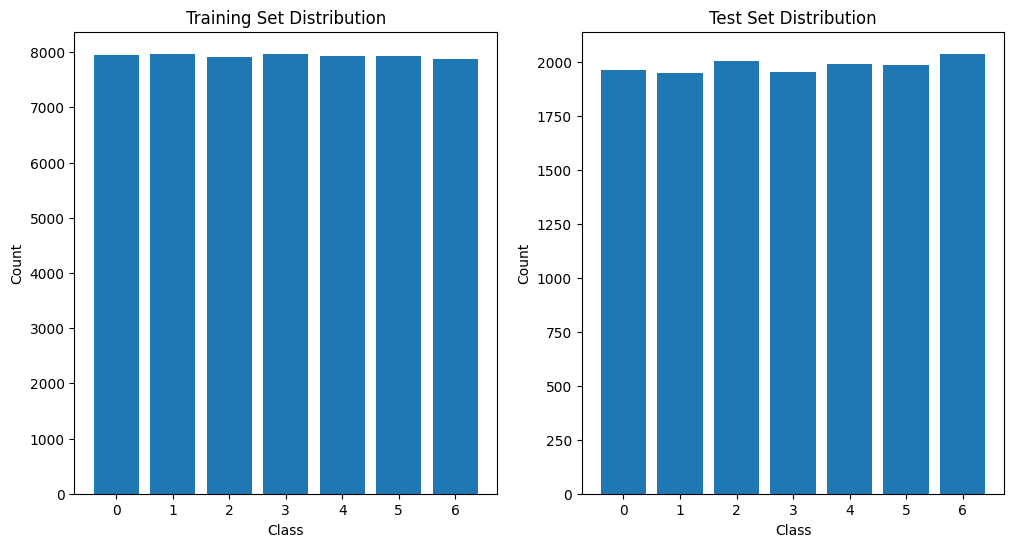

In [6]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)
counts_train = np.unique(y_train, return_counts=True)
counts_test = np.unique(y_test, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(counts_train[0], counts_train[1])
ax[0].set_title('Training Set Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

ax[1].bar(counts_test[0], counts_test[1])
ax[1].set_title('Test Set Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.show()

# 3. Architecture 

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EMGFANNew(1, number_gestures, similarparameter=False)
model.to(device)

EMGFANNew(
  (first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=576, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=576, out_features=128, bias=True)
    (activation): GELU(approximate='none')
  )
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh3): ReLU()
  (last): Linear(in_features=256, out_features=7, bias=True)
)

# 4. Training and Validation

In [8]:
epochs = 15
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels'  

In [9]:
def train_loop(model, train_device, data, loss_fn, optimizer):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X, y in data:


        optimizer.zero_grad()

        X = X.float().to(train_device)
        y = y.long().to(train_device)
        model = model.to(train_device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        train_loss += loss.item()
        total += y.size(0)
        correct += (y_pred.argmax(1) == y).sum().item()

    return train_loss / total, correct / total

In [10]:
def test_loop(model, train_device, data, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data:
            X = X.float().to(train_device)
            y = y.long().to(train_device)
            model = model.to(train_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            total += y.size(0)
            correct += (y_pred.argmax(1) == y).sum().item()

    return test_loss / total, correct / total

In [11]:
model

EMGFANNew(
  (first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=576, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=576, out_features=128, bias=True)
    (activation): GELU(approximate='none')
  )
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh3): ReLU()
  (last): Linear(in_features=256, out_features=7, bias=True)
)

In [12]:
print(f"Training on {device}")
train_accuracy_per_epoch = []
test_accuracy_per_epoch = []


for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = train_loop(model, device, train_dataloader, criterion, optimizer)
    

    train_accuracy_per_epoch.append(train_acc)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)

print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average Train accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'Last Training accuracy {train_acc*100:.4f}%')

Training on cuda


100%|██████████| 15/15 [01:03<00:00,  4.23s/it]

Epoch 15/15
The Average Train accuracy: 85.0975%
Last Training accuracy 89.4221%


In [13]:
save_dir = f"{save_path}/emgfan_pretrain_{epoch+1}.pth"
torch.save(model.state_dict(), save_dir)

In [14]:
test_loss, test_acc = test_loop(model, device, validation_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

Test accuracy 93.2172%
